## Package Installaion

In [1]:
%pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 10.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 3.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install neuralprophet
%pip install matplotlib
%pip install seaborn
%pip install pickle

  Using cached neuralprophet-0.4.2-py3-none-any.whl (103 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 1.6 MB/s eta 0:00:0000:0100:01
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.17.2-py3-none-any.whl (187 kB)
  Using cached PyMeeus-0.5.11.tar.gz (5.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached korean_lunar_calendar-0.3.1-py3-none-any.whl (9.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.8 MB/s eta 0:00:0000:0100:01
  Using cached ephem-4.1.3-cp39-cp39-macosx_10_9_x86_64.whl (1.4 MB)
  Created wheel for pymeeus: filename=PyMeeus-0.5.1

## Package Importation

In [3]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

from collections import defaultdict

import pickle

## Reading Data

Below we read in the data for train, val and test as well as the associated historical dataframe

In [4]:
categorized_history = pd.read_csv('../data_processing/it_history.csv', index_col=0)

In [17]:
train = pd.read_csv('../data_processing/train_daily.csv', index_col=0).T
val = pd.read_csv('../data_processing/val_daily.csv', index_col=0).T
val = val.iloc[1:,:]
test = pd.read_csv('../data_processing/test_daily.csv', index_col=0).T

## Creating CSV

In [18]:
industry_symbol = categorized_history[['GICS Sub-Industry', 'Symbol']]
# industry_symbol.to_csv('industry_symbol.csv')

## Dictionary Mappings

Below we create mappings for:

- `industry_to_symbol_map` i.e. for a given Industry map to all corresponding Symbols
- `symbol_to_industry_map` i.e. for every Symbol we map to a GICS Industry
- `index_to_symbol_map` i.e. for every `index` we map to a Symbol
- `symbol_to_index_map` i.e. for every Symbol we map to an `index`

In [19]:
industry_to_symbol_map = industry_symbol.groupby('GICS Sub-Industry')['Symbol'].apply(list).to_dict()
symbol_to_industry_map = dict(zip(industry_symbol['Symbol'], industry_symbol['GICS Sub-Industry']))

In [38]:
industry_symbol['Symbol']

0     TRMB
1      GEN
2       BR
3     FTNT
4      FLT
      ... 
61    MPWR
62     GPN
63    NXPI
64     ROP
65     GLW
Name: Symbol, Length: 66, dtype: object

In [20]:
index_to_symbol_map = pd.Series(industry_symbol['Symbol']).to_dict()
symbol_to_index_map = dict(zip(index_to_symbol_map.values(), index_to_symbol_map.keys()))

In [21]:
industry_to_folder_map = {
    'Aerospace & Defense': 'aerospace_defense',
    'Application Software': 'application_software',
    'Data Processing & Outsourced Services': 'data_processing_outsourced_resources',
    'Electric Utilities': 'electric_utilities',
    'Health Care Equipment': 'health_care_equipment',
    'Industrial Machinery': 'industrial_machinery',
    'Multi-Utilities': 'multi_utilities',
    'Oil & Gas Exploration & Production': 'oil_gas_exploration_production',
    'Packaged Foods & Meats': 'packaged_foods_meats',
    'Regional Banks': 'regional_banks',
    'Semiconductors': 'semiconductors',   
}
folder_to_indsutry_map = dict(zip(industry_to_folder_map.values(), industry_to_folder_map.keys()))

## Auxiliary Plotting Functions

In [105]:
def plot_forecast(model, data, periods=0, historic_pred=True, highlight_steps_ahead=None, xlabel='Date', ylabel=None, title=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    fig, ax = plt.subplots(figsize=(14,10))

    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

    else:    
        model.plot(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

In [23]:
def plot_validation(metrics_df, metrics = ['SmoothL1Loss', 'MAE', 'RMSE']):
    met_len = len(metrics)

    fig, axs = plt.subplots(ncols=len(metrics), nrows=1, sharex=True, sharey=True, figsize=(8*met_len, 8))
    fig.suptitle('Validation Metrics', fontsize=20, y=0.95)

    if met_len == 1:
        metric = metrics[0]
        axs.plot(metrics_df[metric], 'ob', linewidth=6, label='Training Loss', markersize='3')
        axs.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='Validation Loss')

        axs.set_xlabel('Training Loss')
        axs.set_ylabel('Validation Loss')
        axs.set_title(metric)
        axs.legend()
    else:
        for metric, ax in zip(metrics, axs.ravel()):
            ax.plot(metrics_df[metric], 'ob', linewidth=6, label='Training Loss', markersize='3')
            ax.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='Validation Loss')

            ax.set_xlabel('Training Loss')
            ax.set_ylabel('Validation Loss')
            ax.set_title(metric)
            ax.legend()

## Base Model (Train)
---

Below we define the base model alongside the addition of country holidays in the US

In [50]:
base_model = NeuralProphet(
    growth='linear',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, # To include 7 days worth of AR lag
    num_hidden_layers=8, # 8 hidden layers for the network
    d_hidden=64, # Dimension of hidden layers of AR-Net
    learning_rate=None, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)

base_model.add_country_holidays('USA') # Adds effects of US holidays

## Additive Events

In [51]:
black_monday = pd.DataFrame(
    {
        "event": "2022 Meta Layoffs",
        "ds": pd.to_datetime(
            [
                "20-08-08",
            ]
        ),
    }
)

covid_start = pd.DataFrame(
    {
        "event": "Start of COVID-19 Lockdown",
        "ds": pd.to_datetime(
            [
                "2020-01-10",
            ]
        ),
    }
)

### Create Events Dataframe for IT Sector

In [52]:
# model = base_model
# train_inp = pd.DataFrame(train[0])
# train_inp=train_inp.reset_index()
# train_inp=train_inp.rename(columns = {'index' : 'ds', 0:'y'})
# val_inp = pd.DataFrame(val[0])
# val_inp=val_inp.reset_index()
# val_inp=val_inp.rename(columns = {'index' : 'ds', 0:'y'})
# metrics = model.fit(train_inp, freq="D", validation_df = val_inp)

In [247]:
has_historical_df = False
read_in_model_and_metrics = False
model_dict = defaultdict()

# for industry, symbols in industry_to_symbol_map.items():
    # model_dict[industry] = defaultdict()
for symbol in industry_symbol['Symbol']:

    base_model = NeuralProphet(
    growth='discontinuous',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, # To include 7 days worth of AR lag
    num_hidden_layers=8, # 8 hidden layers for the network
    d_hidden=64, # Dimension of hidden layers of AR-Net
    learning_rate=None, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
    )




    model = base_model
    train_inp = pd.DataFrame(train[symbol_to_index_map[symbol]])
    train_inp=train_inp.reset_index()
    train_inp=train_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
    val_inp = pd.DataFrame(val[symbol_to_index_map[symbol]])
    val_inp=val_inp.reset_index()
    val_inp=val_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
    metrics = model.fit(train_inp,freq="D", validation_df= val_inp)
    ## Pickling model and metrics
    model_path = '../model/model_store/' + symbol +'_model.pickle'
    metrics_path = '../model/metrics_store/' + symbol+'_metric.pickle'


    with open(model_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(metrics_path, 'wb') as handle:
        pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



In [243]:
symbol = 'ADP'
base_model = NeuralProphet(
growth='discontinuous',  # Determine trend types: 'linear', 'discontinuous', 'off'
changepoints=None, # list of dates that may include change points (None -> automatic )
n_changepoints= 52, # Number of weeks in a month, looks at a potential changepoint evey month
changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
trend_reg_threshold=False, # Requires regularization for trend to be changed
yearly_seasonality=True, # Automatically fits yearly seasonality
weekly_seasonality='auto', # Automatically fits weekly seasonality
daily_seasonality='auto', # Automatically fits daily seasonality
seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
n_forecasts=1, # Set at default 1 for forecasting one step ahead
n_lags=7, # To include 7 days worth of AR lag
num_hidden_layers=8, # 8 hidden layers for the network
d_hidden=64, # Dimension of hidden layers of AR-Net
learning_rate=None, # Automatically determines learning rate
epochs=None, # Automatically sets the learning rate (based on data size)
loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
# normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)




model = base_model
train_inp = pd.DataFrame(train[symbol_to_index_map[symbol]])
train_inp=train_inp.reset_index()
train_inp=train_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
val_inp = pd.DataFrame(val[symbol_to_index_map[symbol]])
val_inp=val_inp.reset_index()
val_inp=val_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
metrics = model.fit(train_inp,freq="D", validation_df= val_inp)

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([541])) that is different to the input size (torch.Size([541, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



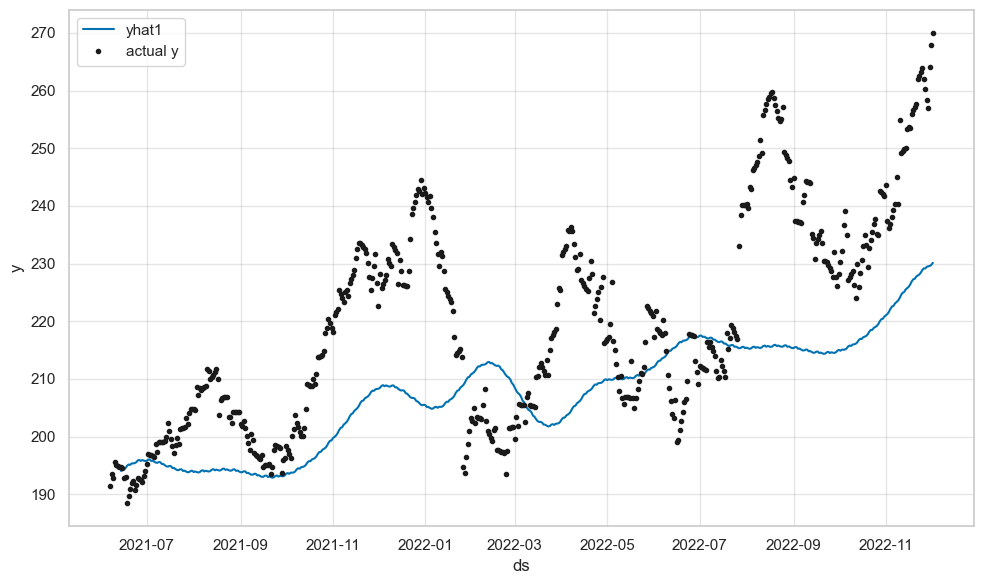

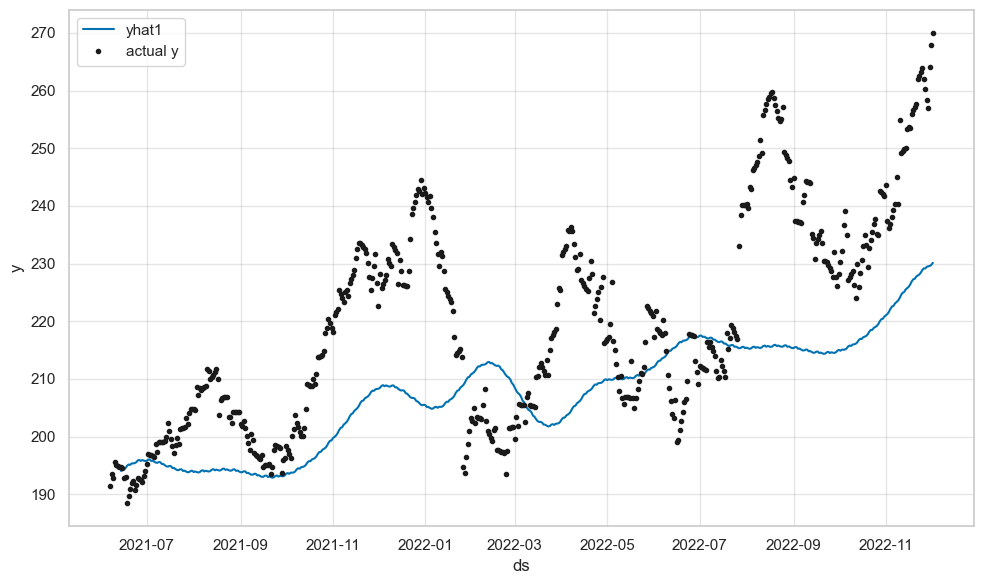

In [244]:
test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
forecast = model.predict(df=test_inp)
model.plot(forecast)

In [238]:
# model_path = '../model/model_store/' + symbol +'special_model.pickle'



# with open(model_path, 'wb') as handle:
#     pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Creating & Predicting Into Future

In [173]:
symbol = 'AAPL'
filename = '../model/model_store/'+symbol+'_model.pickle'
model = pickle.load(open(filename, 'rb'))
test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
forecast = model.predict(df=future)

In [174]:
forecast

,ds,y,residual1,yhat1,ar1,trend,season_yearly,season_weekly
0,2021-06-07,124.804108,NaN,None,None,None,None,None
1,2021-06-08,125.636803,NaN,None,None,None,None,None
2,2021-06-09,126.023399,NaN,None,None,None,None,None
3,2021-06-10,125.012283,NaN,None,None,None,None,None
4,2021-06-11,126.241486,NaN,None,None,None,None,None
...,...,...,...,...,...,...,...,...
540,2022-11-29,141.169998,-71.063332,70.106667,42.52253,27.291485,0.25814,0.034514
541,2022-11-30,148.029999,-77.973198,70.056801,42.52253,27.190178,0.229569,0.114525
542,2022-12-01,148.309998,-78.480675,69.829323,42.52253,27.088898,0.20167,0.016223
543,2022-12-02,147.809998,-78.162788,69.647209,42.52253,26.987568,0.174344,-0.03723


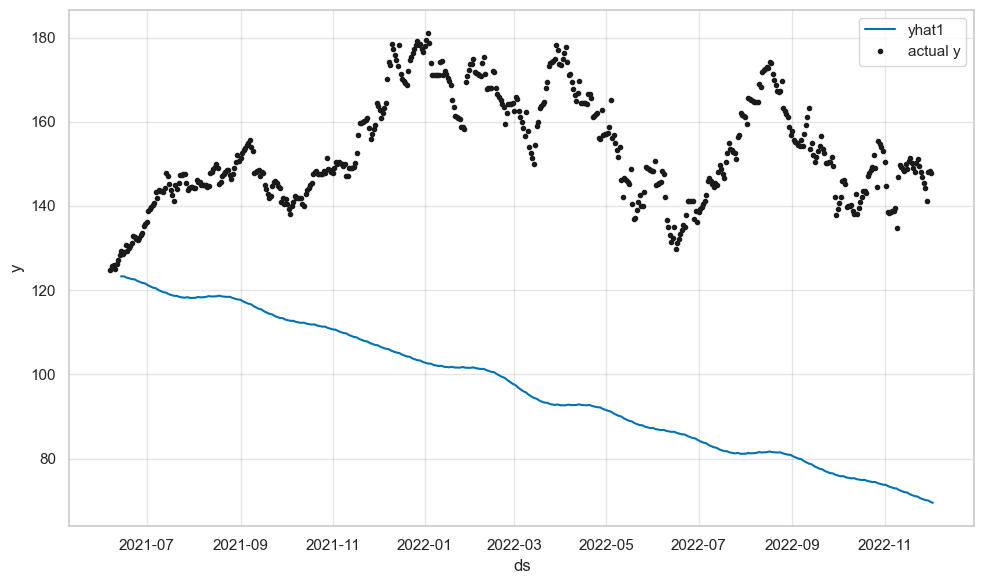

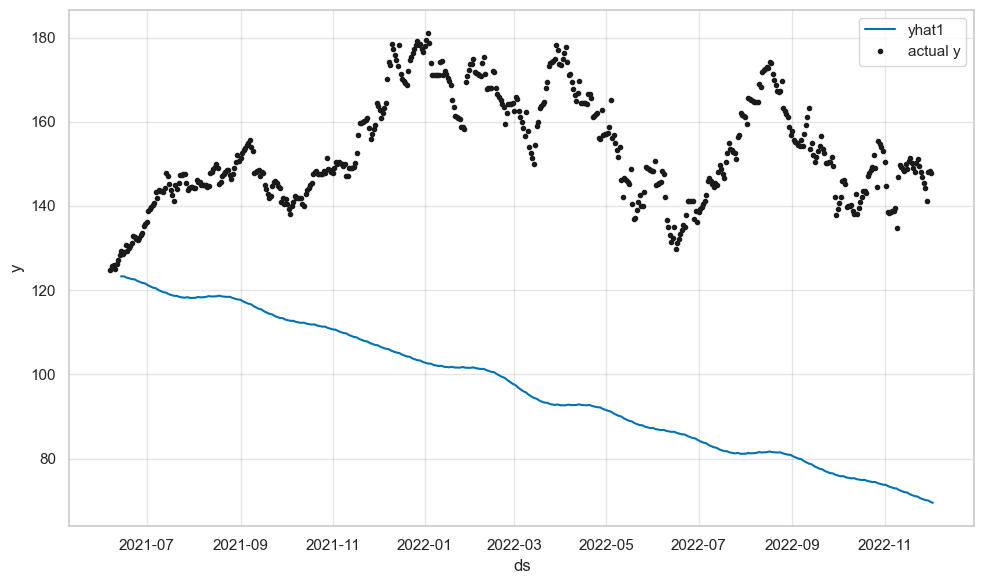

In [175]:
model.plot(forecast)

In [176]:
symbol = 'AAPL'
filename = '../model/model_store/'+symbol+'_model.pickle'
model = pickle.load(open(filename, 'rb'))

test_inp = pd.DataFrame(train[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
forecast = model.predict(df=future)

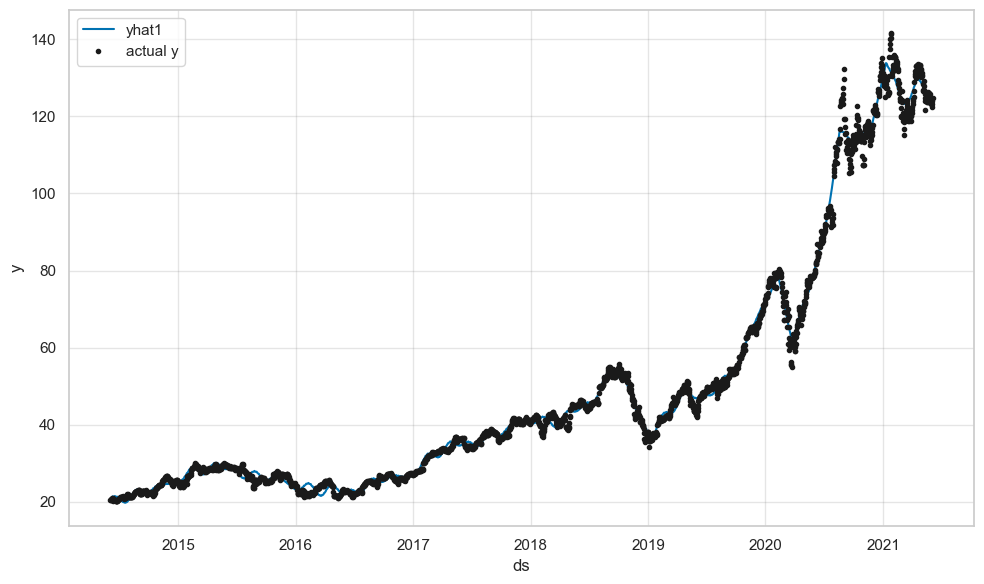

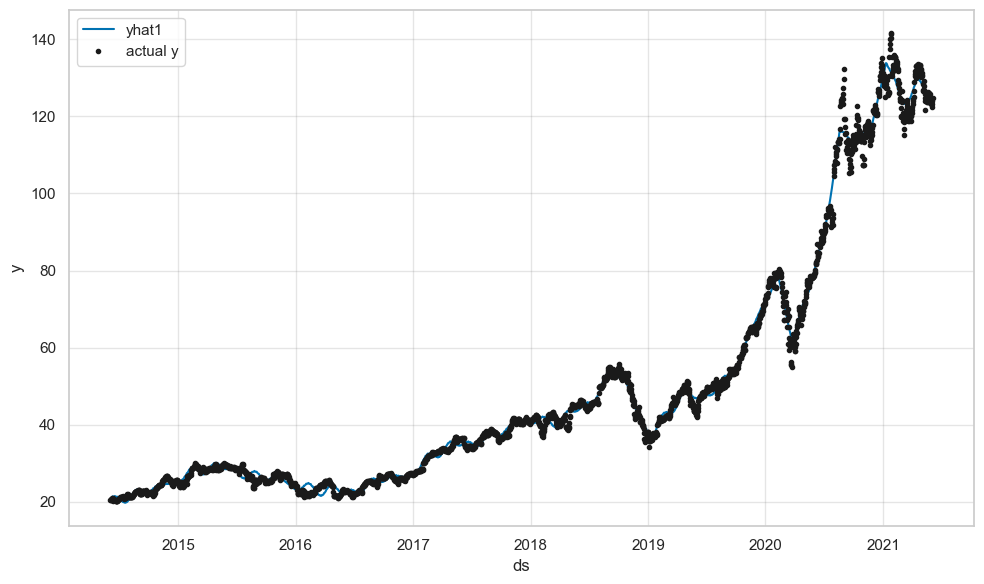

In [178]:
model.plot(forecast)

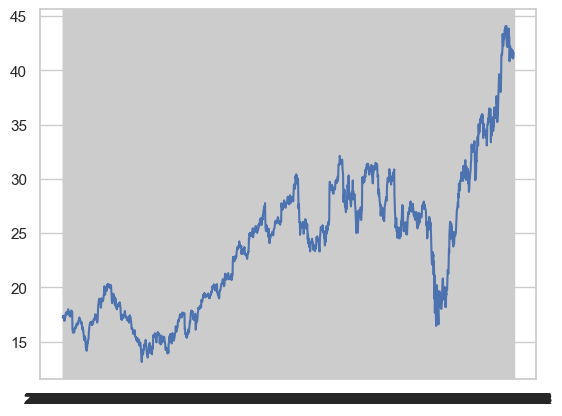

In [142]:
plt.plot(train_inp['ds'], train_inp['y'])

In [113]:
train_inp

,ds,y
0,2014-06-04,17.195070
1,2014-06-05,17.372173
2,2014-06-06,17.364124
3,2014-06-09,17.275568
4,2014-06-10,17.372173
...,...,...
1759,2021-05-28,41.811420
1760,2021-06-01,41.322678
1761,2021-06-02,41.092682
1762,2021-06-03,41.380177


In [114]:
test_inp

,ds,y
0,2021-06-07,40.824356
1,2021-06-08,41.217262
2,2021-06-09,40.977684
3,2021-06-10,41.246017
4,2021-06-11,41.361015
...,...,...
373,2022-11-28,33.110001
374,2022-11-29,33.410000
375,2022-11-30,34.130001
376,2022-12-01,34.240002
